In [1]:
import numpy as np
import scipy
from scipy import linalg
from matplotlib import pyplot as plt
import functools as ftls
import networkx as nx
import copy
from itertools import combinations
%matplotlib inline
import sys
from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))
np.set_printoptions(threshold=sys.maxsize)

X = np.array([[0.0, 1.0], [1.0, 0.0]])
Y = np.array([[0.0,-1.0j],[1.0j,0.0]], dtype = 'complex')
Z = np.array([[1.0, 0.0], [0.0, -1.0]])
I = np.array([[1.0, 0.0], [0.0, 1.0]])

In [2]:
def new_graph(d, n):
    graph = nx.random_regular_graph(d, n)
    return graph, d, n

def isomorphism_check(x, y):
    isomorphic = nx.is_isomorphic(x, y)
    return isomorphic

def is_graph_connected(g):
    connected = nx.is_connected(g)
    return connected

def is_graph_regular(g, k):
    regular = nx.is_k_regular(g, k)
    return regular

def generate_graphs(num_edges, num_nodes, num_graphs):
    graph_list = []
    connected_graphs = []
    regular_graphs = []
    graph_only =[]
    if num_nodes < 4 and num_edges < 2:
        graph_only.append(new_graph(num_edges,num_nodes))
        return graph_only
    else :
        for i in range(num_graphs):
            graph_list.append(new_graph(num_edges,num_nodes))
        for i in range(len(graph_list)):
            if (is_graph_regular(graph_list[i][0], num_edges)):
                regular_graphs.append(graph_list[i])
        for i in range(len(regular_graphs)):
            if (is_graph_connected(regular_graphs[i][0])):
                connected_graphs.append(regular_graphs[i])
        check = True
        graphs = copy.deepcopy(connected_graphs)
        while (check) and (len(graphs) > 1):
            for i, j in combinations(graphs, 2):
                check = isomorphism_check(i[0], j[0])
                if check:
                    graphs.remove(i)
                    break
        return graphs

In [233]:
def MaxCut_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    for edge in edges:
        edge = np.sort(edge)
        H_problem += (np.real(ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, 
                                   np.eye(2**(edge[1]-edge[0]-1)),
                                   operator, np.eye(2**(qubits-edge[1]-1))]))) * (-1/2)
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

'''def MaxClique_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    graph = nx.Graph(edges)
    graph_c = nx.complement(graph)
    edges_c = graph_c.edges
    for edge in edges_c:
        edge = np.sort(edge)
        H_problem += 3/4 * (np.real(ftls.reduce(np.kron, 
                                   [np.eye(2**edge[0]), operator, np.eye(2**(edge[1]-edge[0]-1)), operator, np.eye(2**(qubits-edge[1]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, np.eye(2**(qubits-edge[0]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**(edge[1])), operator, np.eye(2**(qubits-edge[1]-1))])))
    for j in range(qubits):
        H_problem += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem'''

def MaxClique_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    graph = nx.Graph(edges)
    graph_c = nx.complement(graph)
    edges_c = graph_c.edges
    for edge in edges_c:
        edge = np.sort(edge)
        H_problem += 3 * (np.real(ftls.reduce(np.kron, 
                                   [np.eye(2**edge[0]), operator, np.eye(2**(edge[1]-edge[0]-1)), operator, np.eye(2**(qubits-edge[1]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, np.eye(2**(qubits-edge[0]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**(edge[1])), operator, np.eye(2**(qubits-edge[1]-1))])))
    for j in range(qubits):
        H_problem += (-1.0) * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def Hamiltonian_d(qubits, operator):
    H_driver = np.zeros([2**qubits]*2, dtype = operator.dtype)
    for j in range(qubits):
        H_driver += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    return H_driver

def eigenV(Hamilt):
    eigenValues, eigenVectors = np.linalg.eigh(Hamilt)
    return eigenVectors, eigenValues

def commutator(A, B, anti = False):
    if not anti:
        return A @ B - B @ A
    elif anti:
        return A @ B + B @ A

def exeFALQON(graphs, qubits):
    h_p_values = []
    graph_for_FALQON =[]
    beta_values = []
    cost_function_values = []
    phi_values = []
    psi_values = []
    H_p_eigenValues = []
    g = 0
    print(len(graphs))
    H_d = Hamiltonian_d(qubits, X)
    eigenVectors_d, eigenValues_d = eigenV(H_d)
    for g in range(len(graphs)):
        graph_for_FALQON = graphs[g]
        #H_p = MaxCut_p(graph_for_FALQON[0].edges, qubits, Z)
        H_p = MaxClique_p(graph_for_FALQON[0].edges, qubits, Z)
        h_p_values.append(H_p)
        eigenVectors_p, eigenValues_p = eigenV(H_p)
        dt = 0.03
        n_steps = 500
        beta = [0]
        psi_list = []
        phi_list = []
        
        psi_0 = eigenVectors_d[:, 0]
        #U_p = linalg.expm(-1j*H_p*dt) #2d array
        U_p = np.exp(-1j*np.diag(H_p)*dt) #1d array
        comm = (1j*commutator(H_d, H_p, anti = False))
        cost_function = [float(np.real(np.conj(np.transpose(psi_0)) @ H_p @ psi_0))]#
        U_d = linalg.expm(-1j*beta[0]*H_d*dt)
        #psi = U_d @ U_p @ psi_0 #1d array
        psi = U_d @ (U_p*psi_0) #2d array
        A = float(np.real(np.conj(np.transpose(psi)) @ comm @ psi))
        beta.append(-A) #Add -A to beta array
        cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
    
        i = 1
        while i < n_steps:
            U_d = linalg.expm(-1j*beta[i]*H_d*dt)
            #psi2 = U_d @ U_p @ psi #1d array
            psi = U_d @ (U_p*psi) #2d array
            A = float((np.real(np.conj(np.transpose(psi)) @ comm @ psi)))
            beta.append(-A)
            cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
            psi_list.append(psi)
        
            k = 0
            phi = 0
            for k in range(len(eigenValues_p)):
                if eigenValues_p[0] == eigenValues_p[k]:
                    phi =+ phi + ((np.absolute(np.vdot(eigenVectors_p[:,k], psi)))**2)
            phi_list.append(phi)
            i = i+1
        beta_values.append(beta)
        cost_function_values.append(cost_function)
        phi_values.append(phi_list)
        psi_values.append(psi_list)
        H_p_eigenValues.append(eigenValues_p)
    return beta_values, cost_function_values, phi_values, H_p_eigenValues, graphs

In [240]:
k = 2
qubits = 4
num_graphs = 10
graphs = generate_graphs(k, qubits, num_graphs)

In [241]:
beta, cost_function, phi_list, eigenValues_p, num_graphs = exeFALQON(graphs, qubits)

1


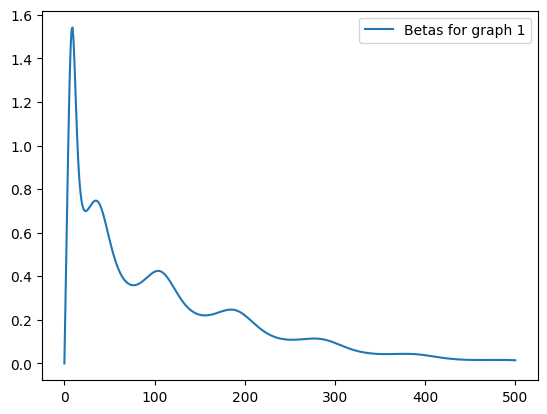

In [242]:
plt.plot(beta[0], label = "Betas for graph 1")
#plt.plot(beta[1], label = "Betas for graph 2")
#plt.plot(beta[2], label = "Betas for graph 3")
#plt.plot(beta[3], label = "Betas for graph 4")
#plt.plot(beta[4], label = "Betas for graph 5")
#plt.plot(beta[5], label = "Betas for graph 6")
#plt.plot(beta[6], label = "Betas for graph 7")
#plt.plot(beta[7], label = "Betas for graph 8")
#plt.plot(beta[8], label = "Betas for graph 9")
#plt.plot(beta[9], label = "Betas for graph 10")
plt.legend()
plt.show()

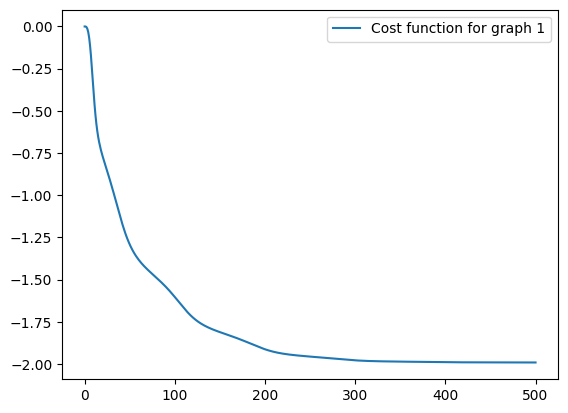

In [243]:
plt.plot(cost_function[0], label = "Cost function for graph 1")
#plt.plot(cost_function[1], label = "Cost function for graph 2")
#plt.plot(cost_function[2], label = "Cost function for graph 3")
#plt.plot(cost_function[3], label = "Cost function for graph 4")
#plt.plot(cost_function[4], label = "Cost function for graph 5")
#plt.plot(cost_function[5], label = "Cost function for graph 6")
#plt.plot(cost_function[6], label = "Cost function for graph 7")
#plt.plot(cost_function[7], label = "Cost function for graph 8")
#plt.plot(cost_function[8], label = "Cost function for graph 9")
#plt.plot(cost_function[9], label = "Cost function for graph 10")
plt.legend()
plt.show()

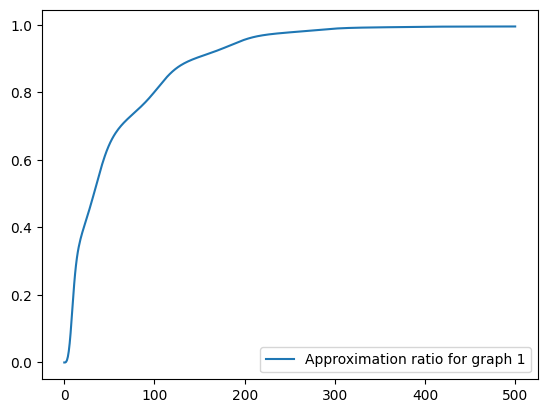

In [244]:
approximation_ratio1 = cost_function[0]/eigenValues_p[0][0]
#approximation_ratio2 = cost_function[1]/eigenValues_p[1][0]
#approximation_ratio3 = cost_function[2]/eigenValues_p[2][0]
#approximation_ratio4 = cost_function[3]/eigenValues_p[3][0]
#approximation_ratio5 = cost_function[4]/eigenValues_p[4][0]
#approximation_ratio6 = cost_function[5]/eigenValues_p[5][0]
#approximation_ratio7 = cost_function[6]/eigenValues_p[6][0]
#approximation_ratio8 = cost_function[7]/eigenValues_p[7][0]
#approximation_ratio9 = cost_function[8]/eigenValues_p[8][0]
#approximation_ratio9 = cost_function[9]/eigenValues_p[9][0]
plt.plot(approximation_ratio1, label = "Approximation ratio for graph 1")
#plt.plot(approximation_ratio2, label = "Approximation ratio for graph 2")
#plt.plot(approximation_ratio3, label = "Approximation ratio for graph 3")
#plt.plot(approximation_ratio4, label = "Approximation ratio for graph 4")
#plt.plot(approximation_ratio5, label = "Approximation ratio for graph 5")
#plt.plot(approximation_ratio6, label = "Approximation ratio for graph 6")
#plt.plot(approximation_ratio7, label = "Approximation ratio for graph 7")
#plt.plot(approximation_ratio8, label = "Approximation ratio for graph 8")
#plt.plot(approximation_ratio9, label = "Approximation ratio for graph 9")
#plt.plot(approximation_ratio9, label = "Approximation ratio for graph 10")
plt.legend()
plt.show()

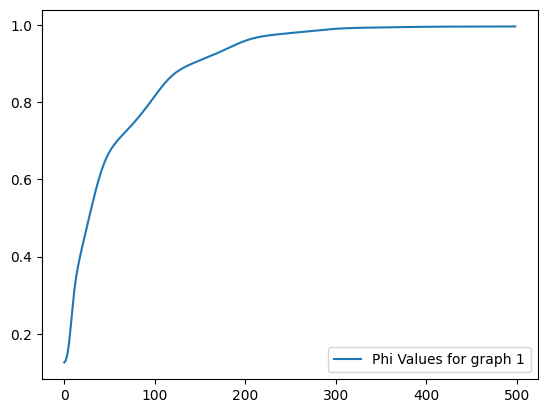

In [245]:
plt.plot(phi_list[0], label = "Phi Values for graph 1")
#plt.plot(phi_list[1], label = "Phi Values for graph 2")
#plt.plot(phi_list[2], label = "Phi Values for graph 3")
#plt.plot(phi_list[3], label = "Phi Values for graph 4")
#plt.plot(phi_list[4], label = "Phi Values for graph 5")
#plt.plot(phi_list[5], label = "Phi Values for graph 6")
#plt.plot(phi_list[6], label = "Phi Values for graph 7")
#plt.plot(phi_list[7], label = "Phi Values for graph 8")
#plt.plot(phi_list[8], label = "Phi Values for graph 9")
#plt.plot(phi_list[9], label = "Phi Values for graph 10")
plt.legend()
plt.show()

In [134]:
len(beta)

2

In [ ]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
graph = nx.Graph(edges)
H1 = MaxClique_p(edges, 5, Z)

In [ ]:
H2 = np.real(
   (np.kron(Z, np.kron(I, np.kron(I, np.kron(Z, I))))*0.75) +
    (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
    (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Z))))*0.75) +
    (np.kron(I, np.kron(Z, np.kron(I, np.kron(Z, I))))*0.75) +
    (np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I))))*0.25) +
    (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Z))))*0.75) +
    (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I))))*0.25) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Z))))*0.75))

In [ ]:
linalg.norm(H1-H2)
print(np.diag(H1).tolist(), np.diag(H2).tolist(), sep='\n')
np.diag(H1)/np.diag(H2)

In [ ]:
H_p = np.real(
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(Z, I))))*0.75) +
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Z))))*0.75) +
            (np.kron(I, np.kron(Z, np.kron(I, np.kron(Z, I))))*0.75) +
            (np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I))))*0.25) +
            (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Z))))*0.75) +
            (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I))))*0.25) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Z))))*0.75))

comm = ((np.kron(I, np.kron(I, np.kron(I, np.kron(Y, I))))*(-12)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Y))))*(-12)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(I, I))))*(-6)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(Z, I))))*(6)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(I, Z))))*(6)) +
        (np.kron(I, np.kron(Y, np.kron(I, np.kron(Z, I))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(Y, np.kron(I, Z))))*(6)) +
        (np.kron(Z, np.kron(I, np.kron(I, np.kron(Y, I))))*(6)) +
        (np.kron(I, np.kron(Z, np.kron(I, np.kron(Y, I))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(Y, Z))))*(6)) +
        (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Y))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Y))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Y))))*(6)))

In [19]:
edges = [(0,1),(0,7),(0,9),(1,11),(1,6),(4,10),(4,5),(4,7),(10,3),(10,6),(3,8),(3,9),(8,5),(8,11),(7,2),(2,6),(2,11),(5,9)]
graph = nx.Graph(edges)
graph_c = nx.complement(graph)
edges_c = graph_c.edges
print(edges_c)

[(0, 11), (0, 6), (0, 4), (0, 10), (0, 5), (0, 3), (0, 8), (0, 2), (1, 7), (1, 9), (1, 4), (1, 10), (1, 5), (1, 3), (1, 8), (1, 2), (7, 9), (7, 11), (7, 6), (7, 10), (7, 5), (7, 3), (7, 8), (9, 11), (9, 6), (9, 4), (9, 10), (9, 8), (9, 2), (11, 6), (11, 4), (11, 10), (11, 5), (11, 3), (6, 4), (6, 5), (6, 3), (6, 8), (4, 3), (4, 8), (4, 2), (10, 5), (10, 8), (10, 2), (5, 3), (5, 2), (3, 2), (8, 2)]


In [5]:
edges = [(2, 3), (2, 1), (3, 0), (0, 1)]
graph = nx.Graph(edges)
graph_c = nx.complement(graph)
edges_c = graph_c.edges
print(edges_c)

[(2, 0), (3, 1)]
